# This video is sponsored by ADA! An analysis of sponsorships on YouTube

In [1]:
import findspark
findspark.init()

In [2]:
%matplotlib inline

# To avoid timezone warning from Pyarrow
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For regression analysis
import pyarrow.parquet as pq
import statsmodels.formula.api as smf

# PySpark, for Big Data processing
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import year, month, udf, col, explode, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType

# Create a spark session, with custom configuration
import pyspark as psp
config = psp.SparkConf().setAll([
    ('spark.network.timeout', '3601s'),
    ('spark.executor.heartbeatInterval', '3600s'),
])
sc = psp.SparkContext('local', '', conf=config)
spark = SparkSession(sc)

# Pandas API on Spark, for convenience
import pyspark.pandas as ps
ps.set_option("plotting.backend", "matplotlib")

plt.style.use("ggplot") # For beautiful plots :)

## Broad analysis on channels

Let us perform a broad analysis on channels to familiarise ourselves with the data.

In [2]:
PATH_CHANNELS_SRC = 'data/df_channels_en.tsv.gz'

In [8]:
channels_df = pd.read_csv(PATH_CHANNELS_SRC, sep="\t", parse_dates=["join_date"])

In [10]:
print(f'There are a total of {channels_df.shape[0]} channels in the dataset.')
channels_df.head(10)

There are a total of 136470 channels in the dataset


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087
5,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087
6,Music,2014-03-12,UCFFbwnve3yF62-tVXkTyHqg,Zee Music Company,43451109,4241,13.0,2.087
7,Sports,2009-03-17,UCRijo3ddMTht_IHyNSNXpNQ,Dude Perfect,45800000,213,14.0,2.087
8,Entertainment,2015-05-12,UCk8GzjMOrta8yxDcKfylJYw,✿ Kids Diana Show,34700000,599,16.0,2.087
9,Music,2006-08-08,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,42000000,154,17.0,2.087


There are a total of $136'470$ channels in the dataset. Each of them having an assigned category, the number of subscribers and the number of videos among other features.

In [11]:
channels_df.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


The dataset contains only channels that have at least $10'000$ subscribers. The average content creator has $250'000$ subscribers and publishes $700$ videos.

### Number of subscribers per channel category

In [17]:
sorted_channels_df = channels_df.copy()
sorted_channels_df = sorted_channels_df.sort_values(ascending=False, by='subscribers_cc')
print(f'The top 10 channels by subscribers are:')
sorted_channels_df[['category_cc', 'name_cc', 'subscribers_cc']].head(10)

The top 10 channels by subscribers are:


,category_cc,name_cc,subscribers_cc
55,Music,T-Series,112139463
0,Gaming,PewDiePie,101000000
3,Howto & Style,5-Minute Crafts,60600000
1,Education,Cocomelon - Nursery ...,60100000
2,Entertainment,SET India,56018869
4,Sports,WWE,48400000
5,Entertainment,Justin Bieber,46574085
7,Sports,Dude Perfect,45800000
6,Music,Zee Music Company,43451109
9,Music,Ed Sheeran,42000000


The channel with the most subscribers is the _T-Series_ channel with more than $110'000'000$ subscribers, followed by the _PewDiePie_ channel with $101'000'000$ subscribers.

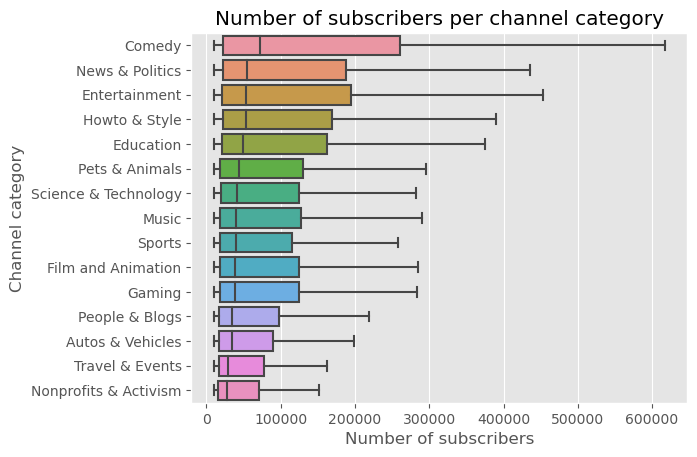

In [15]:
# Order the channels by the number of subscribers per category
grouped = (
    channels_df.loc[:, ["category_cc", "subscribers_cc"]]
    .groupby("category_cc")
    .median()
    .sort_values(by="subscribers_cc", ascending=False)
)

# Plot the categories
sns.boxplot(
    data=channels_df,
    x=channels_df.subscribers_cc,
    y=channels_df.category_cc,
    order=grouped.index,
    showfliers=False,
)
plt.title("Number of subscribers per channel category")
plt.xlabel("Number of subscribers")
plt.ylabel("Channel category")
plt.show()

We removed outliers in the boxplot above for better visualisation. The channel category with the most number of subscribers is _Comedy_, followed by _News & Politics_ and _Entertainment_. _Travel & Events_ and _Nonprofits & Activism_ have the least number of subscribers.

In [23]:
channels_df.groupby("category_cc").max("subscriber_cc").sort_values(by="subscribers_cc", ascending=False)[['subscribers_cc']]

,subscribers_cc
category_cc,
Music,112139463
Gaming,101000000
Howto & Style,60600000
Education,60100000
Entertainment,56018869
Sports,48400000
Film and Animation,29500000
Comedy,24800000
Nonprofits & Activism,20700000


The channel with the most number of subscribers in the category _Travel & Events_ has $4'900'000$ subscribers, which is $22$ times less than the _T-Series_ channel.

### Channels' join date

In [24]:
channels_df.join_date.min(), channels_df.join_date.max()

(Timestamp('2004-09-16 00:00:00'), Timestamp('2019-08-23 00:00:00'))

The channels were created from end of $2004$ to end of $2019$.

Text(0, 0.5, 'Number of channels')

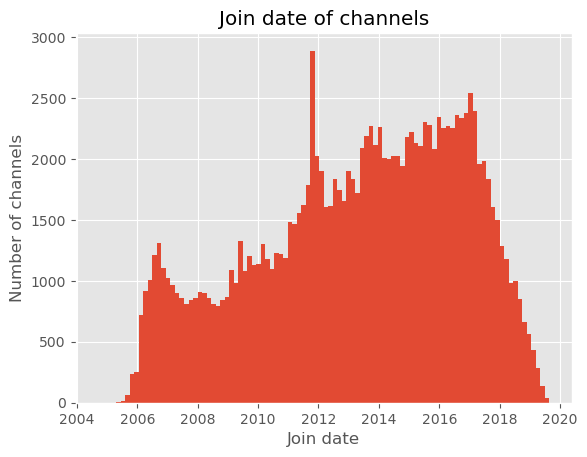

In [27]:
# plot histogram of join dates
channels_df.join_date.hist(bins=100)
plt.title("Join date of channels")
plt.xlabel("Join date")
plt.ylabel("Number of channels")

The decrease in the number of channels joining the platform from $2018$ may be due to the fact that young channels are less likely to reach the $10'000$ subscribers threshold imposed by our dataset.

The channel at index 62 is _YouTube_ itself. It is interesting to note that the channel has no `join_date`.

In [28]:
channels_df.iloc[62].head(65)

category_cc                      Entertainment
join_date                                  NaT
channel               UCBR8-60-B28hp2BmDPdntcQ
name_cc                                YouTube
subscribers_cc                        28200000
videos_cc                                  301
subscriber_rank_sb                       110.0
weights                                  2.087
Name: 62, dtype: object

### Channel with most subscribers

In [29]:
channels_df.loc[channels_df['subscribers_cc'].idxmax()]

category_cc                              Music
join_date                  2006-03-13 00:00:00
channel               UCq-Fj5jknLsUf-MWSy4_brA
name_cc                               T-Series
subscribers_cc                       112139463
videos_cc                                13839
subscriber_rank_sb                       102.0
weights                                  2.087
Name: 55, dtype: object

### Channel with most videos

In [30]:
channels_df.loc[channels_df["videos_cc"].idxmax()]

category_cc                    News & Politics
join_date                  2015-06-17 00:00:00
channel               UCHTK-2W11Vh1V4uwofOfR4w
name_cc                             AP Archive
subscribers_cc                         1770000
videos_cc                               461923
subscriber_rank_sb                      6059.0
weights                                 2.4625
Name: 2795, dtype: object

The channel with the most subscribers is _T-Series_ with more than $110'000'000$ subscribers. The channel with the most videos is _AP Archive_ with more than $460'000$ videos!

## Broad analysis on videos

Let us perform a broad analysis on videos to familiarise ourselves with the data.

In [3]:
#!head -n 1 ./data/yt_metadata_en.jsonl # Linux
!PowerShell.exe gc "./data/yt_metadata_en.jsonl" -head 1 # Windows

{"categories": "Film & Animation", "channel_id": "UCzWrhkg9eK5I8Bm3HfV-unA", "crawl_date": "2019-10-31 20:19:26.270363", "description": "Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids with a nice long video to keep the kids entertained while learning and having fun with the Lego City characters from Lego City undercover. Thanks for watching!", "dislike_count": 1.0, "display_id": "SBqSc91Hn9g", "duration": 1159, "like_count": 8.0, "tags": "lego city,lego police,lego city police,lego city episodes,videos de lego city,lego policia,lego bomberos,lego fire truck,lego firetruck,lego police chase,lego robbers,lego cartoons,lego movies,lego videos for kids", "title": "Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids Episodes", "upload_date": "2016-09-28 00:00:00", "view_count": 1057.0}


In [3]:
PATH_METADATA_SRC = "data/yt_metadata_en.jsonl"
VIDEO_COUNT = 72924794 # The number of data points in the dataset. This result is obtained in a cell below

In [4]:
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])

metadatas_df = spark.read.json(PATH_METADATA_SRC, schema=schema)

# Cast the dislike_count, like_count and view_count to their respective integer type
metadatas_df = metadatas_df \
    .withColumn("dislike_count", metadatas_df.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", metadatas_df.like_count.cast(IntegerType())) \
    .withColumn("view_count", metadatas_df.view_count.cast(LongType()))

In [6]:
metadatas_df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- description: string (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)



In [27]:
# We convert the pyspark dataframe into a pyspark.pandas dataframe
ps_metadatas_df = metadatas_df.pandas_api(index_col="display_id")

In [9]:
# We can see that pandas API provides a better and nicer looking presentation of the dataframe than Spark's own API
ps_metadatas_df.head(5)

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
SBqSc91Hn9g,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego City Police Lego Firetruck Cartoons about...,1,1159,8,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28,1057
UuugEl86ESY,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,1,2681,23,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28,12894
oB4c-yvnbjs,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego City Police Lego Fireman Cartoons about L...,779,1394,1607,"lego city,lego police,lego city police,lego fi...",Lego City Police Lego Fireman Cartoons about L...,2016-09-28,1800602
ZaV-gTCMV8E,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego Harry Potter Complete Lego New Movie for ...,24,5064,227,"Lego harry potter,new harry potter,harry potte...",Lego Harry Potter Complete Lego New Movie for ...,2016-09-28,57640
cGvL7AvMfM0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego City Police LONG VIDEO for kids Lego Fire...,13,3554,105,"lego city,lego police,lego city police,lego fi...",Lego City Police 1 HOUR LONG VIDEO for kids Le...,2016-09-28,86368


### Features histogram on full dataset

The histograms shown below are computed on the full dataset. The features are _views_, _likes_, _dislikes_, and _duration_.

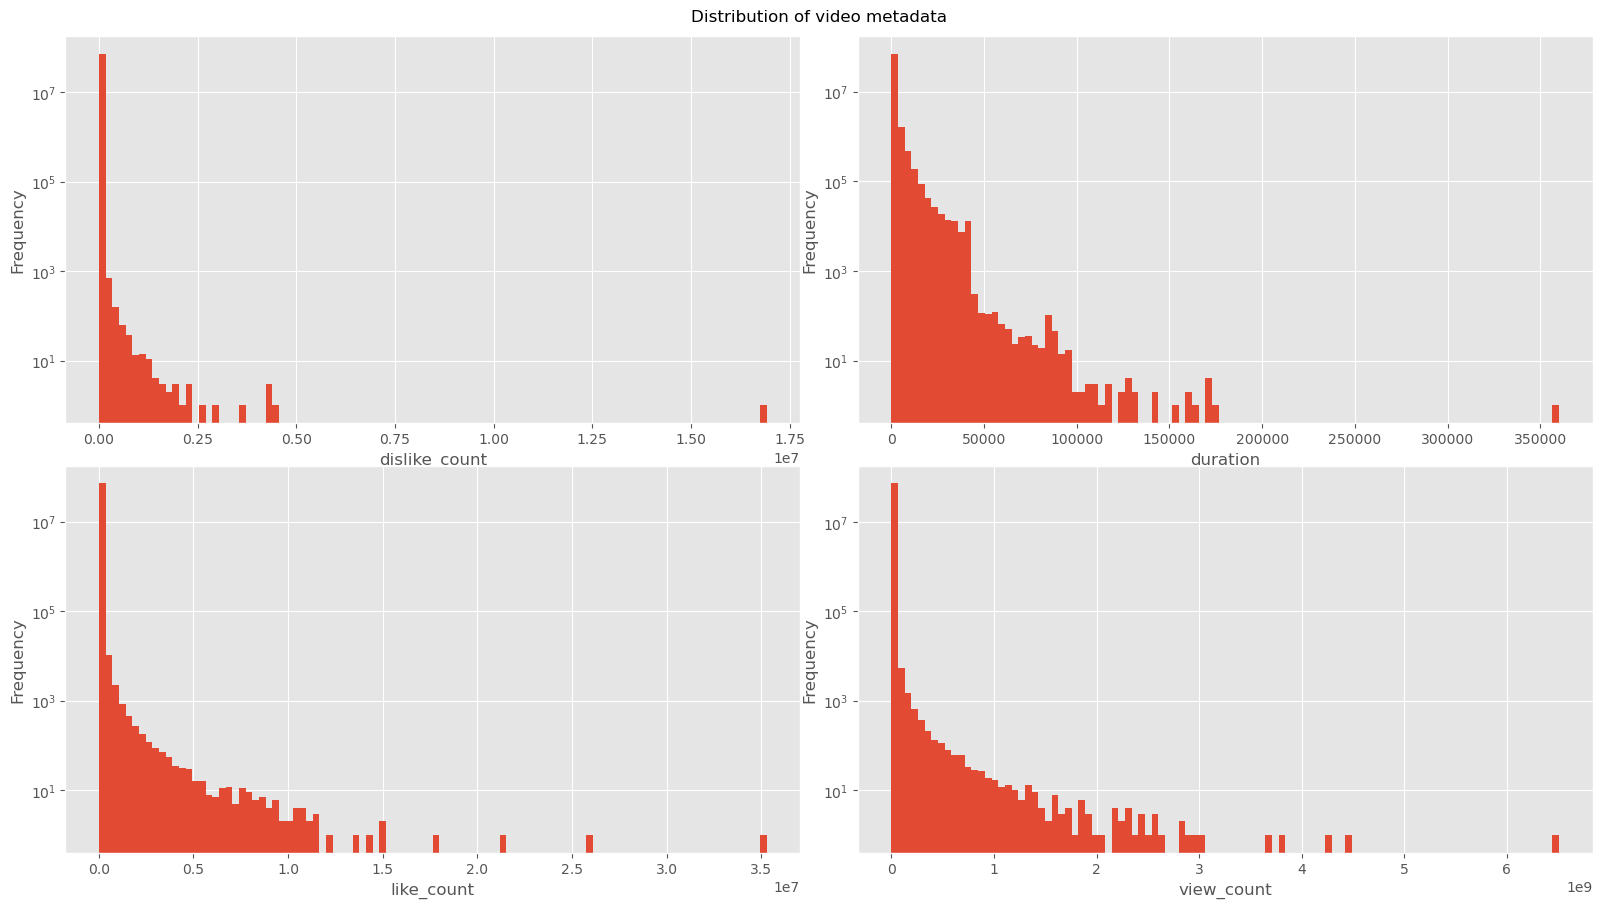

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ps_metadatas_df[["dislike_count", "duration", "like_count", "view_count"]].iloc[:, i].plot.hist(ax=ax, bins=100)
    ax.set_yscale('log')
    ax.set_xlabel(ps_metadatas_df[["dislike_count", "duration", "like_count", "view_count"]].columns[i])
fig.suptitle("Distribution of video metadata")
fig.subplots_adjust(top=0.95)

We can see that all the values follow basically a heavy-tailed distribution.

### Correlations on full dataset

The correlation matrix shown below is computed on the full dataset. The features are _views_, _likes_, _dislikes_, and _duration_.

c:\Users\admin\anaconda3\envs\ada\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<AxesSubplot:>

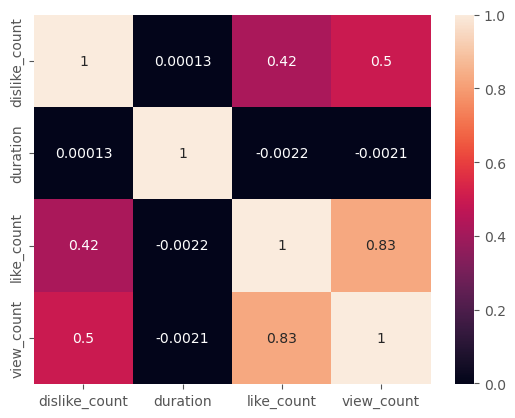

In [11]:
corr = (
    ps_metadatas_df[["dislike_count", "duration", "like_count", "view_count"]]
    .dropna()
    .corr()
)
sns.heatmap(corr.to_pandas(), annot=True)

We can see the `like_count` and the `view_count` are highly corrolated. This seems logical as the more views a video has, the more people could like it.

### Features histogram on a random subsample

As we have a big dataset, one might ask what would happen if we take a random smaller sample from the dataset. We hence reproduce the same visualisations but by taking only $0.1\%$ of the total data to plot these.

In [5]:
# We select only a small subsample from the dataset without replacement and convert it to a pandas dataframe
random_sub = (
    metadatas_df.select("dislike_count", "duration", "like_count", "view_count")
    .sample(withReplacement=False, fraction=0.001, seed=None)
    .toPandas()
)

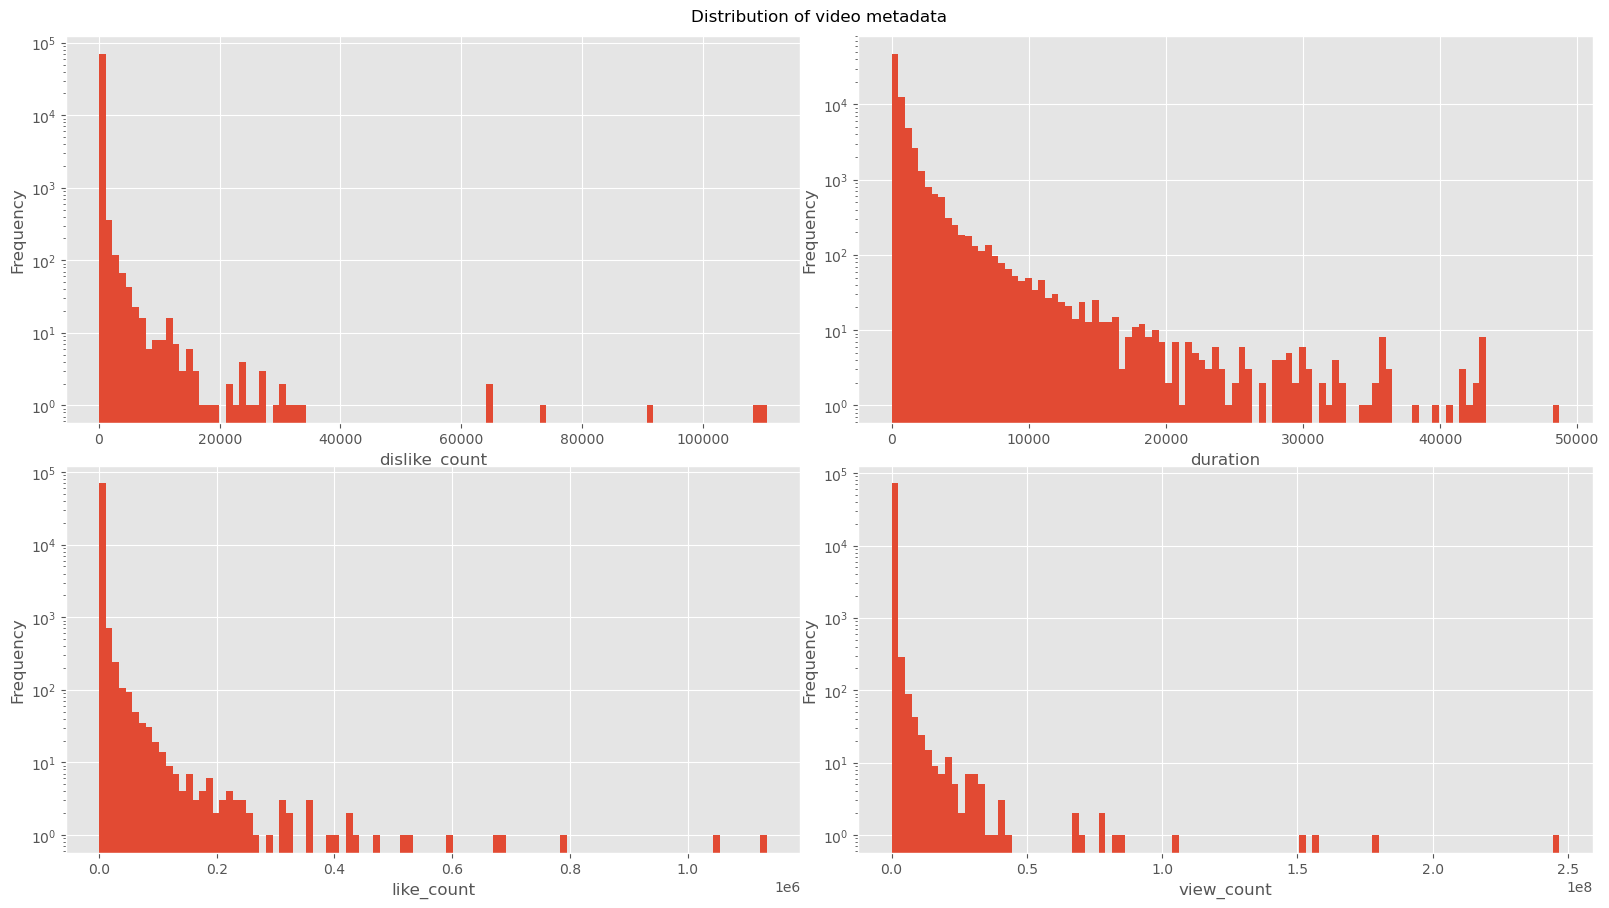

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
for i, ax in enumerate(axes.flatten()):
    random_sub.iloc[:, i].plot.hist(ax=ax, bins=100)
    ax.set_yscale("log")
    ax.set_xlabel(random_sub.columns[i])
fig.suptitle("Distribution of video metadata")
fig.subplots_adjust(top=0.95)

We can see that the distributions looks similar to the one with all datapoints with the exception of "outliers".

We will plot the same histograms on a loglog scale to better visualise the distributions.

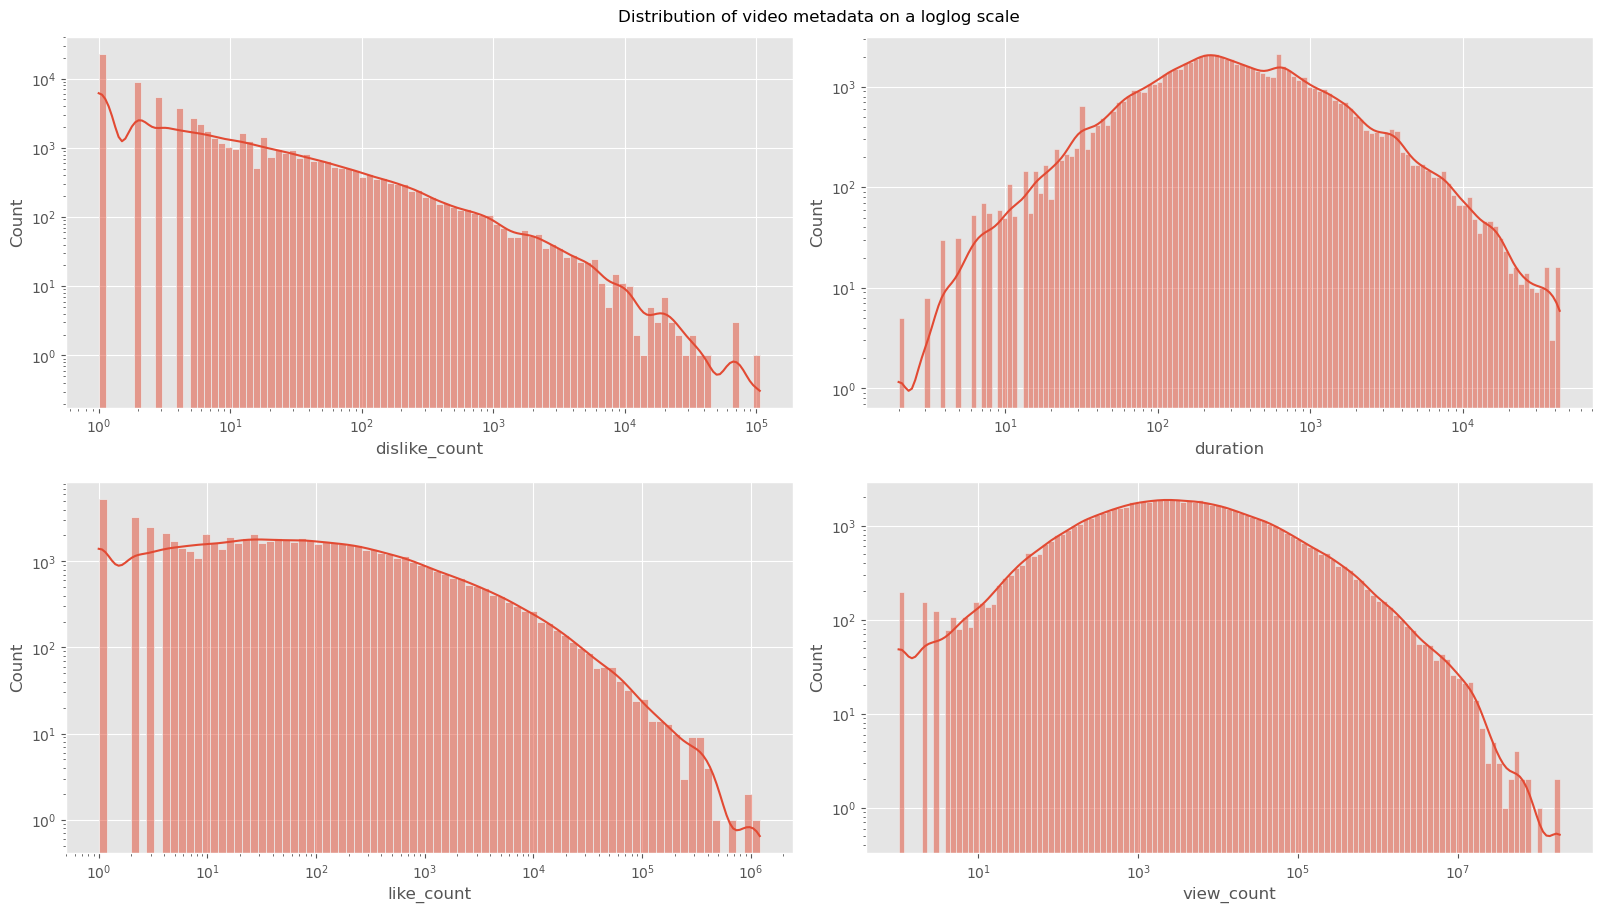

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.set_yscale("log")
    sns.histplot(data=random_sub.iloc[:, i] + 1, ax=ax, kde=True, log_scale=True)
fig.suptitle("Distribution of video metadata on a loglog scale")
fig.subplots_adjust(top=0.95)
fig.subplots_adjust(hspace=0.2, wspace=0.1)

Both _duration_ and _views_ seem to follow a log-normal distribution. The _likes_ and _dislikes_ features are right-skewed.

### Correlations on a random subsample

<AxesSubplot:>

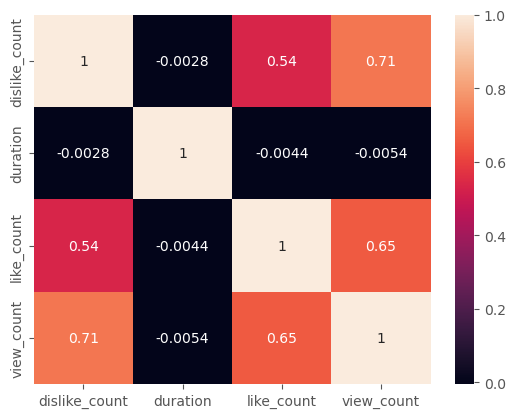

In [15]:
sns.heatmap(random_sub.corr(), annot=True)

The correlation between `like_count` and `view_count` is still high.

### Missing values

We now check for any missing values in the dataset.

In [16]:
# We take all the dataset, including display_id which was set as the index in the previous dataframe
metadatas_df.pandas_api().isnull().any()

categories       False
channel_id       False
crawl_date       False
description      False
dislike_count     True
display_id       False
duration         False
like_count        True
tags             False
title            False
upload_date      False
view_count        True
dtype: bool

Here we check if any columns contains NaN values and we can see that `dislike_count`, `like_count` and `view_count` contain null values.

In [ ]:
missing_value_count = (
    ps_metadatas_df[["dislike_count", "like_count", "view_count"]].isna().sum(axis=0)
)
missing_value_count = missing_value_count.to_pandas()

In [25]:
for col, x in missing_value_count.items():
    print(f"{col:14}: {x} ({(x / VIDEO_COUNT):.3%} of entries)")

dislike_count : 1631458 (2.237% of entries)
like_count    : 1631458 (2.237% of entries)
view_count    : 654 (0.001% of entries)


### Basic statistics on numerical values

In [18]:
metadatas_df.select(
    "dislike_count", "duration", "like_count", "view_count"
).summary().show()

+-------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|          duration|        like_count|        view_count|
+-------+------------------+------------------+------------------+------------------+
|  count|          71293336|          72924794|          71293336|          72924140|
|   mean|  76.0915862037933| 757.6761375561788|1306.7580320831107|125237.60820707656|
| stddev|3064.7580067517442|1820.1105064271235|20135.880453098183|  3534488.21672248|
|    min|                 0|                 1|                 0|                 0|
|    25%|                 0|               134|                 6|               532|
|    50%|                 2|               284|                43|              2925|
|    75%|                12|               697|               265|             17423|
|    max|          16916346|            360157|          35287325|        6509934494|
+-------+------------------+------------------+-------

The average video has $1306$ likes, $76$ dislikes, lasts $12$ minutes and has $125'000$ views. They seem to be right-skewed as the median is much lower than the mean.

### Total number of video entries

In [19]:
# This cell was used to define the VIDEO_COUNT constant above
metadatas_df.count()

72924794

There are $72'924'794$ videos in total.

### Number of videos created each month

In [20]:
# Extract year from upload_date
df_dates = (
    metadatas_df
    .withColumn("year", year(metadatas_df.upload_date))
    .withColumn("month", month(metadatas_df.upload_date))
)
df_dates.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- description: string (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [21]:
# Group the videos by year and month and count the number of such videos
vids_per_month = (
    df_dates
        .select("display_id", "year", "month")
        .groupBy("year", "month")
        .count()
)
count_sorted = vids_per_month.toPandas().sort_values(["year", "month"])
count_sorted["date"] = pd.to_datetime(
    count_sorted["year"].astype(str) + count_sorted["month"].astype(str), format="%Y%m"
)

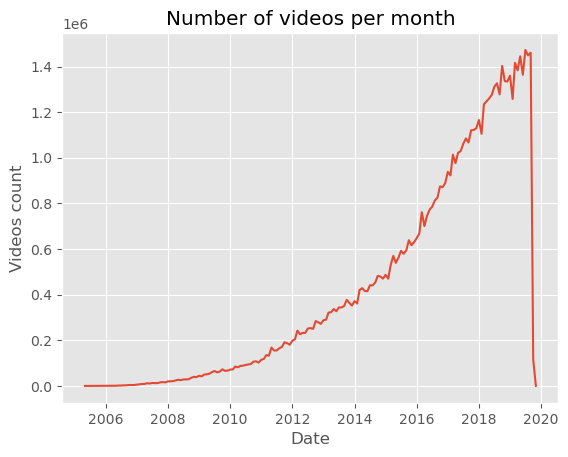

In [22]:
# Plot the number of videos during the years
sns.lineplot(data=count_sorted, x="date", y="count")
plt.title("Number of videos per month")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.show()

We can see that the number of videos published every month grows in a somewhat exponential manner. We can see that at the end of $2019$, the count drastically drops. This is simply explained by the fact that the crawling stopped at that time and hence we did not get a full month of video crawling.

### Group videos by year and categories

In [23]:
# Group the videos by year and month and count the number of such videos
count_cat = (
    df_dates.select("display_id", "categories", "year")
    .groupBy("year", "categories")
    .count()
    .toPandas()
)
count_cat.head()

,year,categories,count
0,2019,Entertainment,2226961
1,2010,News & Politics,97464
2,2014,Comedy,90952
3,2019,News & Politics,2566841
4,2011,Music,285111


In [26]:
# We list the categories that exist for videos
cats = set()
for x in count_cat.categories:
    cats.add(x)
cats

{'',
 'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'Howto & Style',
 'Movies',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Shows',
 'Sports',
 'Travel & Events'}

In [27]:
# Fill missing year-category combinations with 0
count_cat_idx = (
    count_cat.set_index(["year", "categories"])
    .unstack(fill_value=0)["count"]
    .unstack()
    .reset_index(name="count")
    .reset_index()
)

In [28]:
# Build a dictionnary mapping each category to the number of videos in that category per year
stack = {}
years = range(2005, 2020)
for cat in cats:
    stack[cat] = (
        count_cat_idx[count_cat_idx["categories"] == cat]
        .sort_values("year")["count"]
        .values
    )
stack["None"] = stack.pop("")

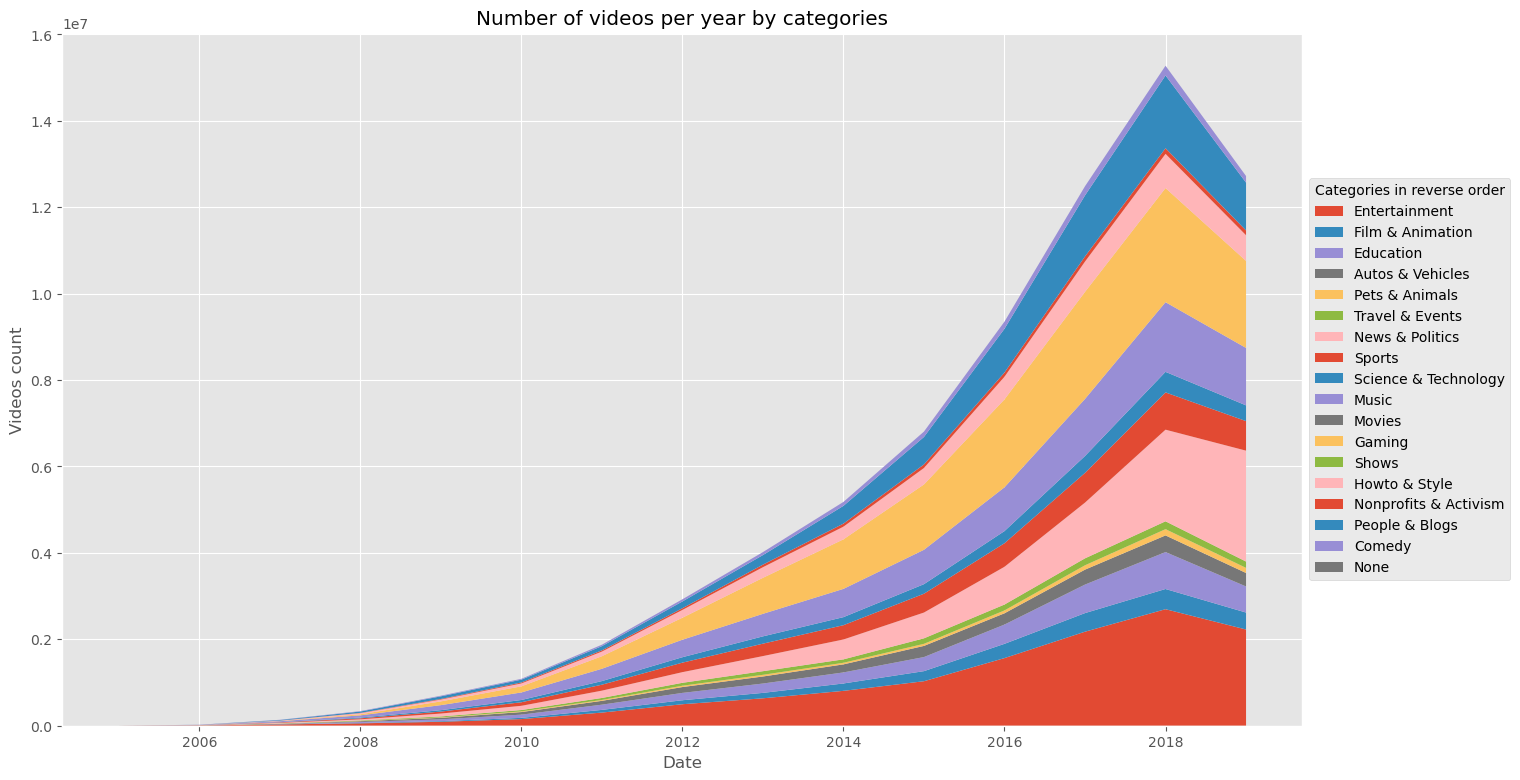

In [29]:
# Plot the number of videos per category per year
plt.figure(figsize=(16, 9))
plt.stackplot(years, stack.values(), labels=stack.keys())
plt.title("Number of videos per year by categories")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.legend(
    title="Categories in reverse order", loc="center left", bbox_to_anchor=(1, 0.5)
)
plt.show()

The _Entertainment_ and _Gaming_ categories seem to become more popular over time. Some categories such as _Comedy_ and _Nonprofits & Activism_ seem to stay relatively constant. Suprisingly, _Science & Technology_ seems to follow the same trend.

### Ratio of number of videos by category per year

In [31]:
# Compute the ratio of videos for each category
count_cat_idx = count_cat_idx.drop("index", axis=1)
vids_per_year = count_cat_idx.groupby(["year"])["count"].sum()
ratios = count_cat_idx.copy()
ratios["ratio"] = ratios.groupby(["year"])["count"].apply(lambda x: x / x.sum())

In [32]:
# Verify that the sum of all ratios gives 100%
ratios.groupby("year")["ratio"].sum()

year
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
Name: ratio, dtype: float64

In [33]:
# The categories contain a category that is '' so we replace it by 'None' to give a better meaning
ratios.categories = ratios.categories.replace('', 'None')

In [34]:
# Ratios per category in 2011
ratios[ratios.year == 2011]

,categories,year,count,ratio
6,None,2011,162,0.000086
21,Autos & Vehicles,2011,88574,0.047240
36,Comedy,2011,32902,0.017548
51,Education,2011,120596,0.064318
66,Entertainment,2011,304094,0.162185
81,Film & Animation,2011,62429,0.033296
96,Gaming,2011,290048,0.154694
111,Howto & Style,2011,108199,0.057707
126,Movies,2011,0,0.000000
141,Music,2011,285111,0.152060


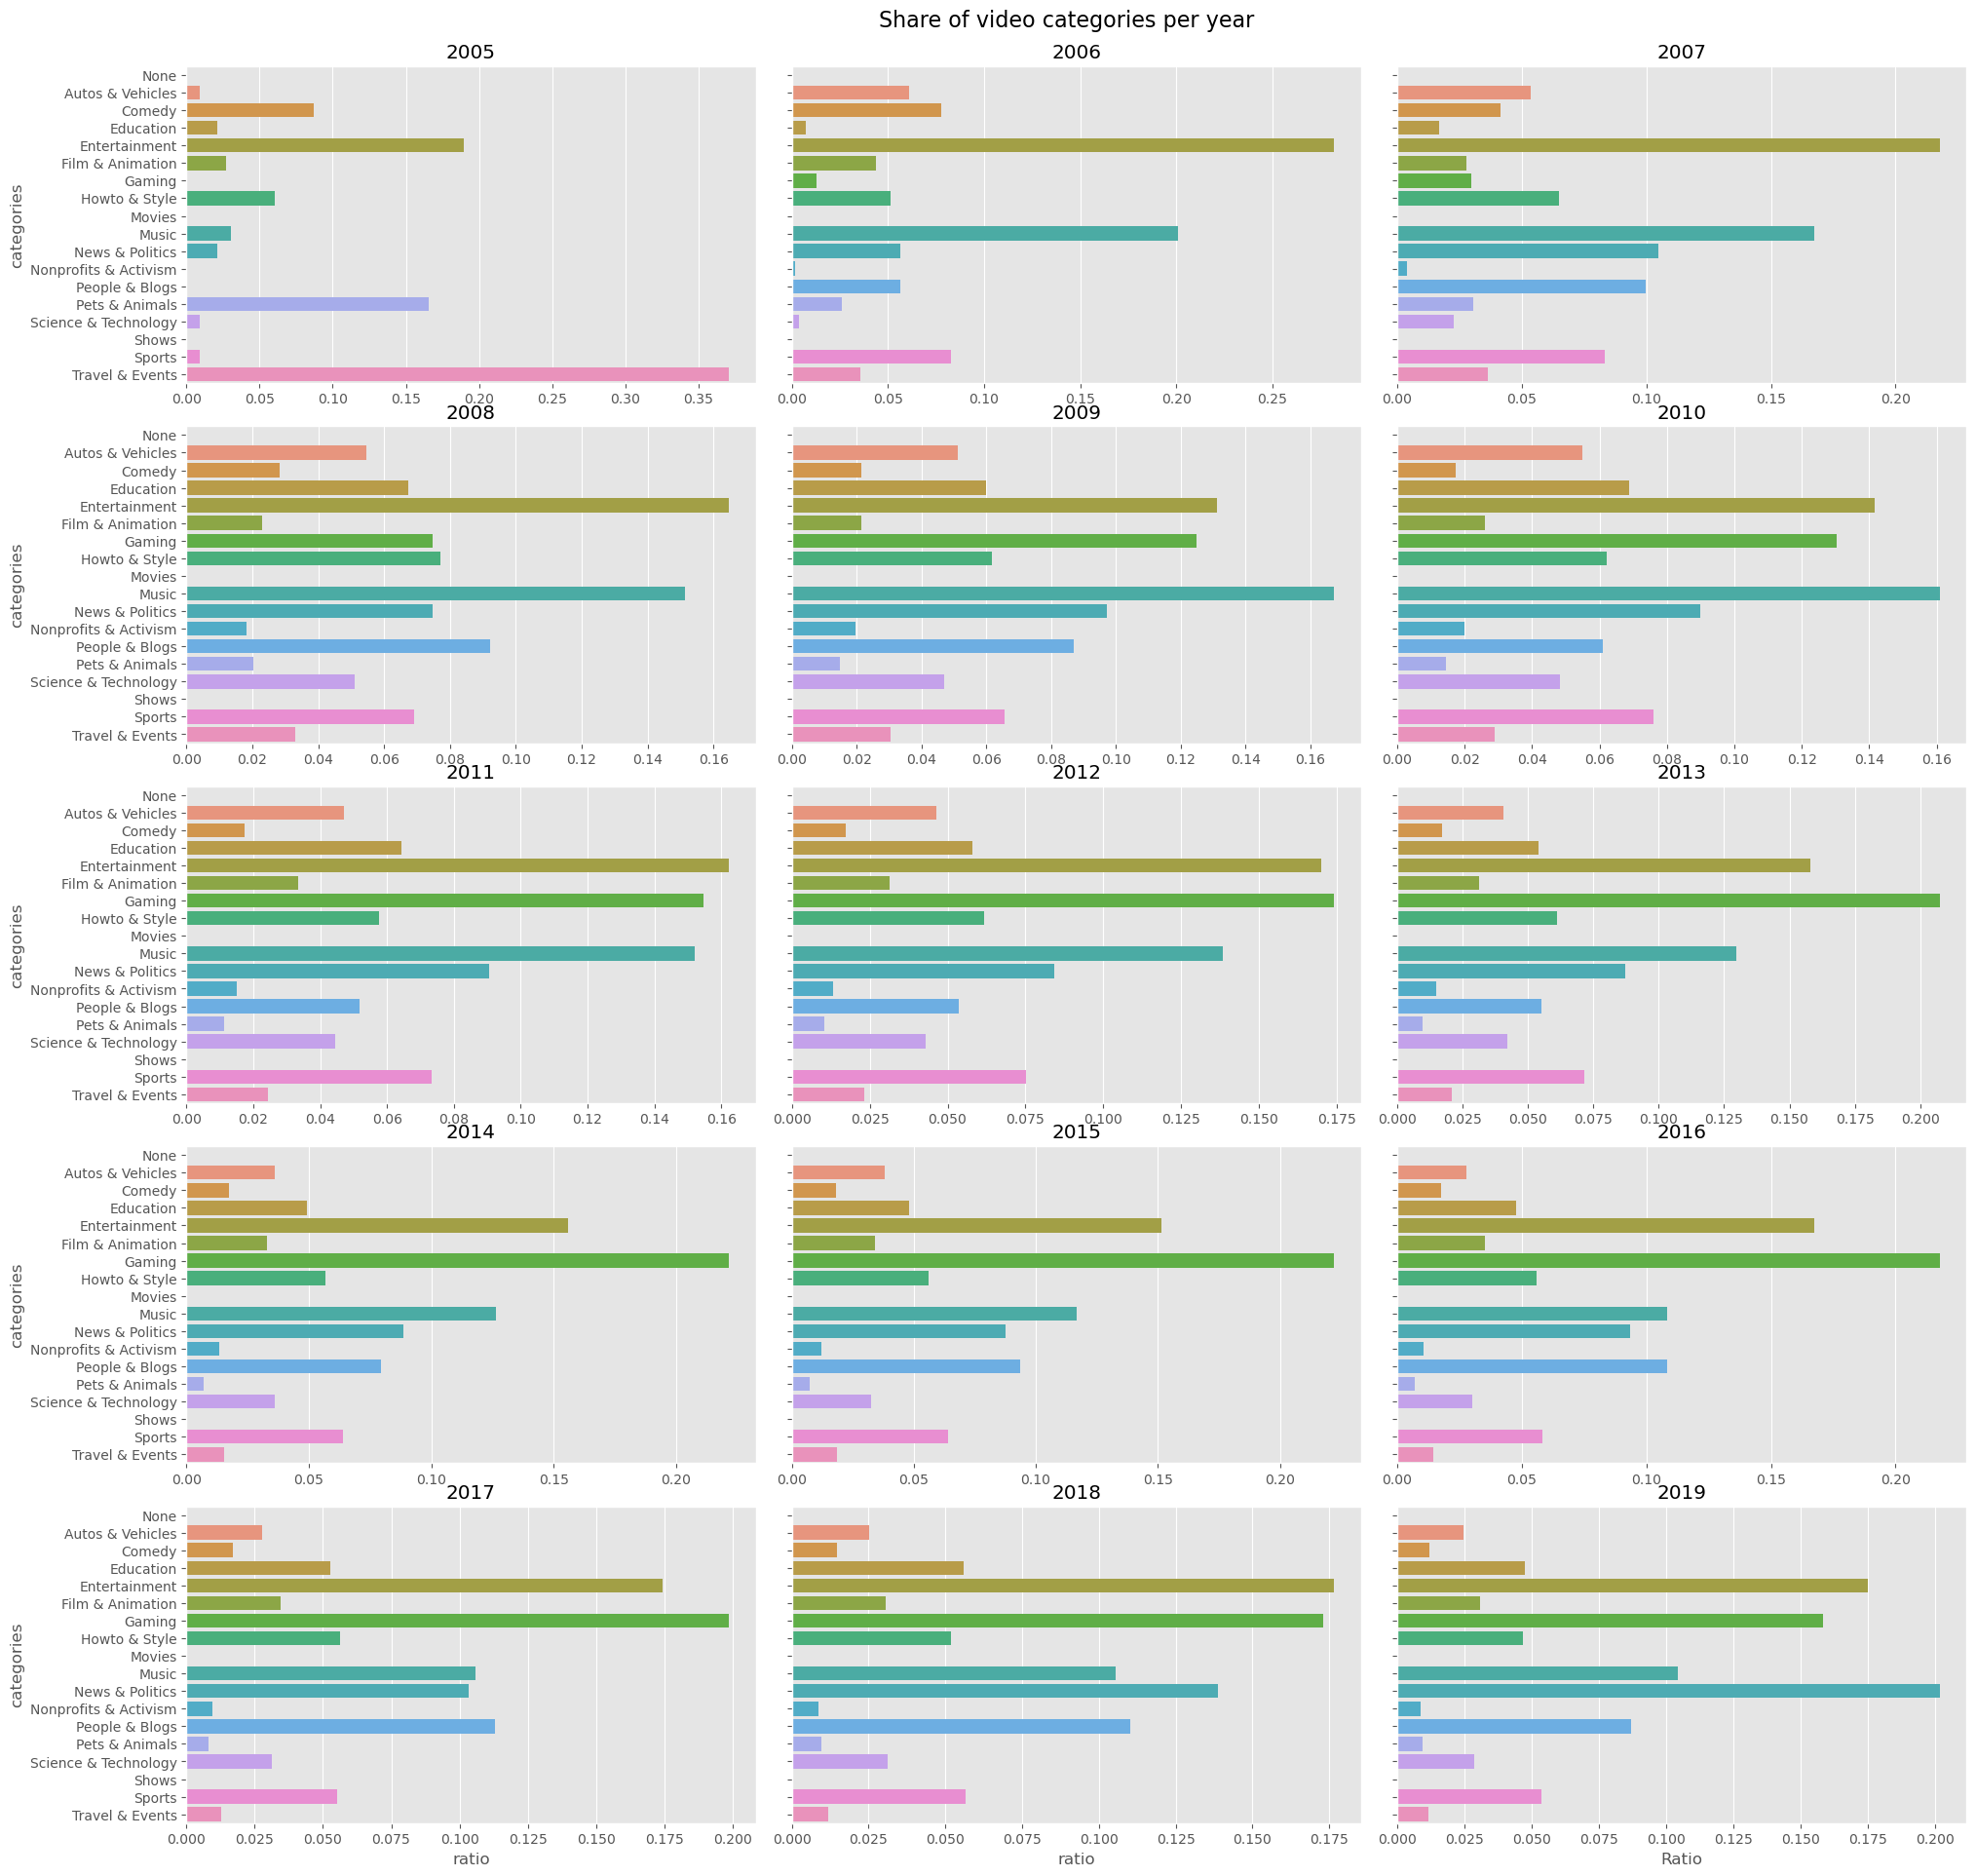

In [35]:
fig, axs = plt.subplots(5, 3, sharey=True, figsize=(19, 19))
fig.suptitle("Share of video categories per year", fontsize=16, y=1)

fig.tight_layout()
for year, ax in zip(years, axs.ravel()):
    p = sns.barplot(
        ax=ax, data=ratios[ratios["year"] == year], y="categories", x="ratio"
    )
    idx = year - 2005
    if idx % 3 != 0:
        p.set(ylabel=None)
    if idx < 12:
        p.set(xlabel=None)
    ax.set_title(year)

plt.xlabel("Ratio")
plt.show()

We can see that the categories `Movies`, `Shows` and `None` do not contain a lot of videos. We explore this in the cells below.

### Movies, Shows and None categories

In [36]:
# Note that we used "None" previously to represent the "" category in the plots
abnormal_cats: pd.DataFrame = ps_metadatas_df[ps_metadatas_df.categories.isin(["Movies", "Shows", ""])].to_pandas()
abnormal_cats.groupby("categories").size()
abnormal_cats[abnormal_cats.categories == "Movies"]

c:\Users\admin\anaconda3\envs\ada\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
L3thFGDGAS8,Movies,UCwaNuezahYT3BOjfXsne2mg,2019-11-11,Let's turn Taylor Swift's OUT OF THE WOODS int...,202.0,229,2146.0,"Out Of The Woods,out of the woods taylor swift...",Taylor Swift - Out Of The Woods PARODY,2016-01-14,170642
rpUkpMfMWtw,Movies,UC6xOVUMstTf08rUgOFbyPEA,2019-11-14,A comical take on the BMC's inefficiency and t...,107.0,273,3608.0,"BMC,government og india,government,indian gove...",SnG: BMC! You Screwed Me,2014-10-27,189267
9wBn1s_l2kE,Movies,UC4zJAMaYN592qQhMR2OfX_Q,2019-11-02,In no other country in the world does a girl's...,19.0,190,877.0,"clisare,irish youtuber,irish girl,funny irish ...",What An Irish Girl's Fake Tan Means | Clisare ...,2015-10-20,32070
UtUH7-mYBLA,Movies,UC4zJAMaYN592qQhMR2OfX_Q,2019-11-02,Why do women listen to songs with such degradi...,38.0,227,576.0,"clisare,misogynistic,Robin Thicke (Musical Art...",SEXIST SONG LYRICS / Clisare,2013-10-14,36410
fVqOyXdDQTc,Movies,UC4zJAMaYN592qQhMR2OfX_Q,2019-11-02,The long-awaited sequel. For the one year anni...,92.0,110,2836.0,"clisare,yeousch,irish,girl,ireland,sydney,coll...",Shite Irish Mammies Say // Clisare,2013-02-24,284059


We can see that all videos with the categories `Movies` came out between $2013$ and $2016$.

In [37]:
abnormal_cats[abnormal_cats.categories == "Shows"].head()

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
RGTIpnn7tKQ,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,http://www.funimation.com/kamisama-kiss\n\nAba...,293.0,1441,15358.0,"funimation,anime,animation,japanese,kamisama k...",Kamisama Kiss - 1 - Nanami Becomes A God,2012-11-28,1342616
45N75Qb-BtU,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,27.0,1470,822.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 1 - Time Again,2012-11-02,90632
HuBY7aX6BpE,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,13.0,1465,427.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 2 - Prelude to Everything,2012-11-02,52095
aXsk5pE7U5k,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,14.0,1465,452.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 4 - The Dismayed Girls,2012-11-02,52371
NjLnlvFNvMA,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,14.0,1465,442.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 3 - The Suspicious Tran...,2012-11-02,51336


In [38]:
abnormal_cats[abnormal_cats.categories == "Shows"].upload_date.min(), abnormal_cats[abnormal_cats.categories == "Shows"].upload_date.max()

(datetime.date(2012, 8, 13), datetime.date(2013, 1, 18))

We can see that the `Shows` category only existed for a small amout of time, between the August $2012$ to January $2013$ ($5$ months).

In [39]:
abnormal_cats[abnormal_cats.categories == ""].head()

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
mv8d1j8O_KY,,UCzS3-65Y91JhOxFiM7j6grg,2019-11-14,Will Ferrell & Adam McKay think back to just l...,NaN,139,NaN,"funnyordie,funny or die,funny,comedy,sketch,lo...",Will Ferrell & Adam McKay Discuss The Art of T...,2017-09-13,9706
dSG8bWaA2vY,,UCzS3-65Y91JhOxFiM7j6grg,2019-11-14,Subscribe to Todd Kruger: http://www.funnyordi...,NaN,206,NaN,"funnyordie,funny or die,funny,comedy,sketch,lo...","Todd Kruger: The Pretentious Bum - ""The Edible...",2016-02-18,3797
D8_baAUFi6k,,UCzQxQEjCprHzJmWmgSLBjqQ,2019-11-18,Release date: 13 of May Download on Beatport: ...,NaN,53,NaN,,Slideback - Harmonica (Original Mix) [OFFICIAL...,2013-05-08,1193
TZmYztItVEQ,,UCzOrpRAPhzLet9lCv1unRqw,2019-11-01,"In the second Live show episode of Love Gurus,...",NaN,4698,NaN,"Love Guru Live Show,Advice On Love and Relatio...",Love Guru Live Show - Episode 2 | Socialpost,2019-06-15,529
mmqtirodB7Y,,UCrpVInV3uywvK-Df0fO12-Q,2019-10-31,Become a sponsor on Patreon and get invited to...,NaN,8035,NaN,"Nintendo Switch,Switch,Nintendo Switch News,Ni...",Nintendo Direct Live Reaction! March 8th 2018,2018-03-08,32264


In [40]:
abnormal_cats[abnormal_cats.categories == ""].upload_date.min(), abnormal_cats[abnormal_cats.categories == ""].upload_date.max()

(datetime.date(2007, 8, 1), datetime.date(2019, 9, 30))

It seems that every video in the `None` category has NaN values for the number of likes and dislikes, we explore this further:

In [41]:
non_null_counts = abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.dislike_count.notnull())].size, \
                  abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.like_count.notnull())].size

print(f"None category videos with dislikes    : {non_null_counts[0]}\n"
      f"None category videos with likes       : {non_null_counts[1]}")

null_counts = abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.dislike_count.isna())].size, \
              abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.like_count.isna())].size

print(f"None category videos with no dislikes : {null_counts[0]}\n"
      f"None category videos with no likes    : {null_counts[1]}")

None category videos with dislikes    : 9042
None category videos with likes       : 9042
None category videos with no dislikes : 7700
None category videos with no likes    : 7700


There are indeed about half of the videos in the `None` category that have NaN values for the number of likes and dislikes.

### Save results

In [42]:
ratios.to_csv("generated/vids_count_by_cat_per_year.csv", index=False)

In [43]:
count_sorted.to_csv("generated/vids_per_month.csv", index=False)

## Visualisation of videos with and without links

In [3]:
FILE = "data/generated/yt_metadata_en_urls.parquet"

schema = StructType([
    StructField("categories",    StringType(),            True),
    StructField("channel_id",    StringType(),            True),
    StructField("crawl_date",    DateType(),              True),
    StructField("dislike_count", DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),            True),
    StructField("duration",      IntegerType(),           True),
    StructField("like_count",    DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),            True),
    StructField("title",         StringType(),            True),
    StructField("upload_date",   DateType(),              True),
    StructField("view_count",    DoubleType(),            True),  # This field must be specified as a double as it is represented as a floating point number
    StructField("urls",          ArrayType(StringType()), True),
    StructField("urls_count",    IntegerType(),           True),
    StructField("has_urls",      BooleanType(),           True),
])

In [4]:
df = spark.read.parquet(FILE, schema=schema)

In [5]:
# Cast the dislike_count, like_count and view_count to their respective integer type
df = (
    df.withColumn("dislike_count", df.dislike_count.cast(IntegerType()))
    .withColumn("like_count", df.like_count.cast(IntegerType()))
    .withColumn("view_count", df.view_count.cast(LongType()))
)

### Total number of video containing urls

The count is $39635552$

In [6]:
df_urls = df.where(df["has_urls"] == "true")
df_urls.count()

39635552

In [7]:
df_urls.select(
    df_urls["dislike_count"],
    df_urls["like_count"],
    df_urls["duration"],
    df_urls["view_count"],
    df_urls["urls_count"],
).summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|        like_count|          duration|        view_count|        urls_count|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          38832948|          38832948|          39635552|          39635121|          39635552|
|   mean| 96.64598407517245|1794.6333588683506| 826.2556941051307|164725.98607447167|3.4811531071902317|
| stddev|3979.7913427365856| 26156.84896760549|1920.2010232393127| 4558197.649328211|4.2989266847036545|
|    min|                 0|                 0|                 1|                 0|                 1|
|    25%|                 0|                12|               152|               852|                 1|
|    50%|                 3|                73|               325|              4455|                 2|
|    75%|                18|               425|        

The average video with urls has $1794$ likes, $96$ dislikes, $3.5$ urls, lasts $13.7$ minutes and has $164'000$ views.

### Total number of video without URLs 

The count is $33289242$

In [8]:
df_no_urls = df.where(df["has_urls"] == "false")
df_no_urls.count()

33289242

In [9]:
df_no_urls.select(
    "dislike_count", "like_count", "duration", "view_count"
).summary().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|     dislike_count|       like_count|          duration|        view_count|
+-------+------------------+-----------------+------------------+------------------+
|  count|          32460388|         32460388|          33289242|          33289019|
|   mean| 51.50198907049417|723.1039736185531| 676.0224735967254| 78221.30427610378|
| stddev|1296.2132088331575|8448.791046188253|1689.6139066050878|1620074.6922409744|
|    min|                 0|                0|                 1|                 0|
|    25%|                 0|                4|               119|               323|
|    50%|                 1|               22|               245|              1756|
|    75%|                 7|              137|               611|             10104|
|    max|           2330721|          8073485|            360157|        1930356913|
+-------+------------------+-----------------+------------------+

The average video with urls has $723$ likes, $51$ dislikes, lasts $11$ minutes and has $78'000$ views.

### Group videos containing URLs by year and categories

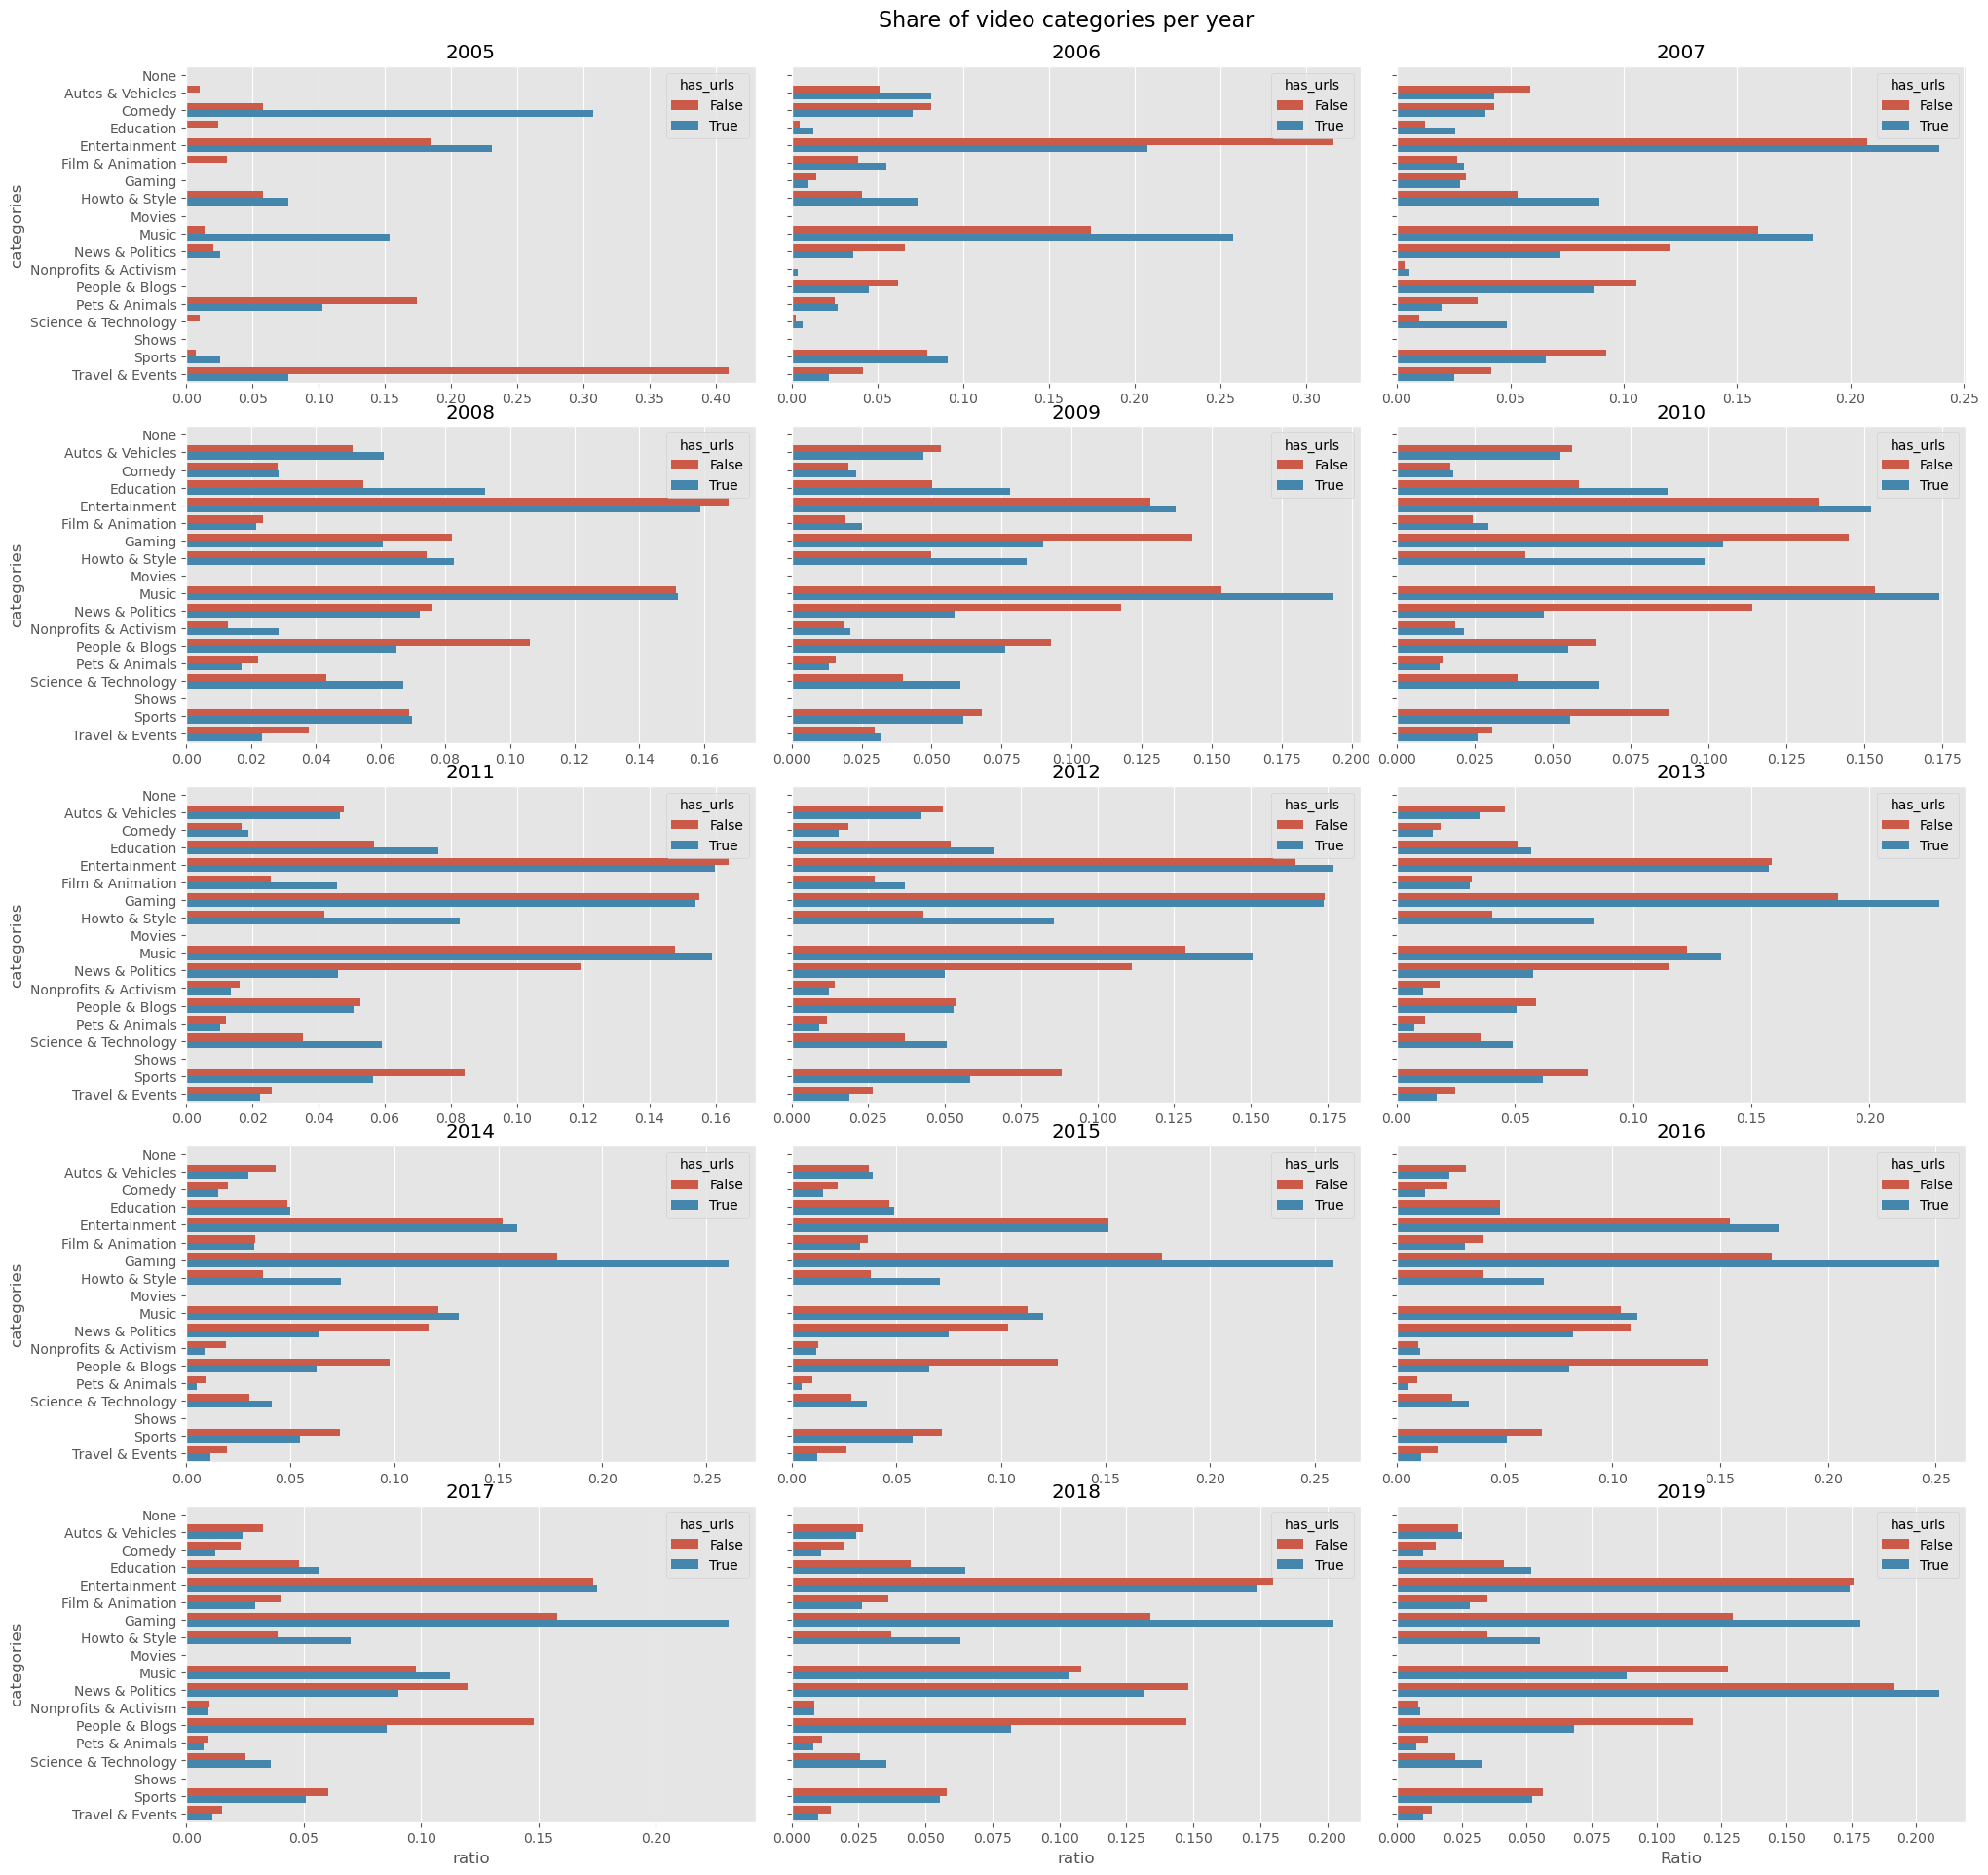

In [74]:
# Video without URLs
df_no_urls = df.where(df["has_urls"] == "false")

# Group the videos by year and month and count the number of such videos
df_dates_no_urls = df_no_urls.withColumn(
    "year", year(df_no_urls.upload_date)
).withColumn("month", month(df_no_urls.upload_date))
vids_per_month_per_cat_no_urls = (
    df_dates_no_urls.select("display_id", "categories", "year")
    .groupBy("year", "categories")
    .count()
)

# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat_no_urls = vids_per_month_per_cat_no_urls.toPandas()
count_cat_idx_no_urls = (
    count_cat_no_urls.set_index(["year", "categories"])
    .unstack(fill_value=0)["count"]
    .unstack()
    .reset_index(name="count")
    .reset_index()
    .drop("index", axis=1)
)
vids_per_year_no_urls = count_cat_idx_no_urls.groupby(["year"])["count"].sum()
ratios_no_urls = count_cat_idx_no_urls.copy()
ratios_no_urls["ratio"] = ratios_no_urls.groupby(["year"])["count"].apply(
    lambda x: x / x.sum()
)
ratios_no_urls.categories = ratios_no_urls.categories.replace("", "None")
ratios_no_urls["has_urls"] = False

# videos with URLs
df_urls = df.where(df["has_urls"] == "true")

# Group the videos by year and month and count the number of such videos
df_dates = df_urls.withColumn("year", year(df_urls.upload_date)).withColumn(
    "month", month(df_urls.upload_date)
)
vids_per_month_per_cat = (
    df_dates.select("display_id", "categories", "year")
    .groupBy("year", "categories")
    .count()
)

# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat = vids_per_month_per_cat.toPandas()
count_cat_idx = (
    count_cat.set_index(["year", "categories"])
    .unstack(fill_value=0)["count"]
    .unstack()
    .reset_index(name="count")
    .reset_index()
    .drop("index", axis=1)
)
vids_per_year = count_cat_idx.groupby(["year"])["count"].sum()
ratios = count_cat_idx.copy()
ratios["ratio"] = ratios.groupby(["year"])["count"].apply(lambda x: x / x.sum())
ratios.categories = ratios.categories.replace("", "None")
ratios["has_urls"] = True

# Combine two ratios
all_ratios = pd.concat([ratios, ratios_no_urls])

fig, axs = plt.subplots(5, 3, sharey=True, figsize=(19, 19))
fig.suptitle("Share of video categories per year", fontsize=16, y=1)

fig.tight_layout()

years = range(2005, 2020)
for ye, ax in zip(years, axs.ravel()):
    p = sns.barplot(
        ax=ax,
        data=all_ratios[all_ratios["year"] == ye],
        y="categories",
        x="ratio",
        hue="has_urls",
    )

    idx = ye - 2005
    if idx % 3 != 0:
        p.set(ylabel=None)
    if idx < 12:
        p.set(xlabel=None)
    ax.set_title(ye)


plt.xlabel("Ratio")
plt.show()

The _Music_ category has significantly more videos with URLs, which may be due to the fact that music videos are more likely to have links to the artist's website or streaming platform. Since we did not filter out Spotify or Apple Music links, these could be counted as URLs.

The _Entertainment_ category has nearly the same number of videos with and without URLs. 

The _People & Blogs_ category has significantly more videos without URLs. This may be due to the fact that they might add links to their social media accounts, which were indeed filtered by our regex.

### Number of URLs per video in time

In [76]:
urls_vid_per_year = (
    df_dates.select("display_id", "year", "urls_count").groupBy("year").count()
)
count = urls_vid_per_year.toPandas()

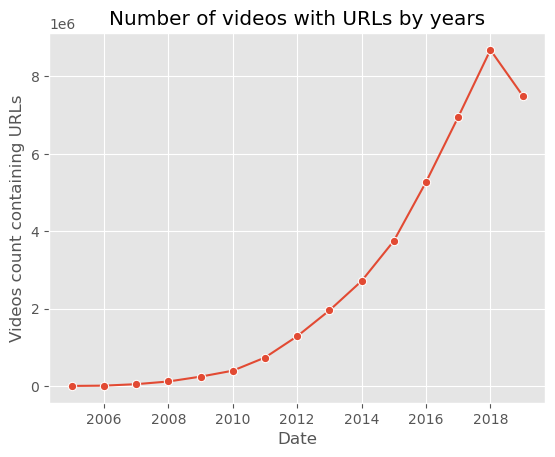

In [80]:
sns.lineplot(data=count, x="year", y="count", marker="o")
plt.title("Number of videos with URLs by years")
plt.xlabel("Date")
plt.ylabel("Videos count containing URLs")
plt.show()

It naturally follows the same trend as the number of videos per month.

## Regression analysis on videos with and without links

In this part, we perform a regression analysis on sponsored videos. As our current dataset only takes into account links in the description, our definition of a sponsored video may not reflect reality as good as we would like at the moment. Nevertheless, this analysis might give us better insights in the future.

In [3]:
PATH_METADATA_W_URLS = "data/yt_metadata_en_urls.parquet"

In [4]:
metadatas_urls_df = spark.read.parquet(PATH_METADATA_W_URLS, sep=",")
metadatas_urls_df.head()

Row(categories='Howto & Style', channel_id='UCROB2-0bJEcwiP059oNil_Q', crawl_date=datetime.date(2019, 11, 17), dislike_count=None, display_id='iICAtB8ViFM', duration=1365, like_count=None, tags='makeup geek,kathleen lights,makeup,wannamakeup,sephora,by terry,ulta,korres,chanel,haul', title='Makeup Haul | Chanel, MAC, Makeup Geek, Sephora & more', upload_date=datetime.date(2016, 8, 22), view_count=2813, urls=['http://go.magik.ly/ml/1fqi/', 'http://go.magik.ly/ml/1fqk/', 'http://go.magik.ly/ml/1fqo/', 'http://go.magik.ly/ml/1fql/', 'http://go.magik.ly/ml/1fqm/', 'http://go.magik.ly/ml/1fqr/', 'http://go.magik.ly/ml/1fqp/', 'http://www.ebates.com/rf.do?referreri...', 'http://go.magik.ly/ml/1fqn/', 'http://go.magik.ly/ml/1fqj/', 'http://go.magik.ly/ml/1fqs/', 'http://go.magik.ly/ml/167n/', 'http://go.magik.ly/ml/1fqq/', 'https://www.octoly.com/creators?cref=hato9'], urls_count=14, has_urls='true')

### Replace NaN values by 0

This will be used to discard those values later, as we do not want to consider undefined values in our regression analysis.

In [5]:
metadatas_urls_df = (
    metadatas_urls_df
    .fillna(0, subset="dislike_count")
    .fillna(0, subset="like_count")
)

### Add like-view ratio

In [6]:
like_view_ratio_udf = udf(
    lambda like, view: 0 if view is None or like is None or view == 0 else like / view,
    FloatType(),
)
metadatas_urls_df = metadatas_urls_df.withColumn(
    "like_per_view",
    like_view_ratio_udf(metadatas_urls_df.like_count, metadatas_urls_df.view_count),
)

In [13]:
metadatas_urls_df.filter(col("like_per_view") == 0).count()

6899121

There are $6'899'121$ videos with a ratio of likes per view of 0, which is less than $10\%$ of our dataset. We can drop them from our analysis, since they might not be considered as sponsored videos.

In [7]:
metadatas_urls_df = metadatas_urls_df.where(metadatas_urls_df.like_per_view > 0)

### Add dislike-view ratio

In [8]:
like_view_ratio_udf = udf(
    lambda dislike, view: 0
    if view is None or dislike is None or view == 0
    else dislike / view,
    FloatType(),
)
metadatas_urls_df = metadatas_urls_df.withColumn(
    "dislike_per_view",
    like_view_ratio_udf(metadatas_urls_df.dislike_count, metadatas_urls_df.view_count),
)

In [16]:
metadatas_urls_df.filter(col("dislike_per_view") == 0).count()

18224671

There are $18'224'671$ videos with a ratio of dislikes per view of 0, which is about $25\%$ of our dataset. We can drop them from our analysis, since they might not be considered as sponsored videos.

In [9]:
metadatas_urls_df = metadatas_urls_df.where(metadatas_urls_df.dislike_per_view > 0)

### Fit a linear regression model

In [10]:
# Run this cell to write the parquet file regression_urls with the columns you want to fit on :
metadatas_urls_df_write = metadatas_urls_df.select(
    col("urls_count"), col("like_per_view")
)
metadatas_urls_df_write.write.parquet("regression_urls.parquet")

In [11]:
# Load the dataset


class DataSet(dict):
    def __init__(self, path):
        self.parquet = pq.ParquetDataset(path)

    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError


df_urls = DataSet("regression_urls.parquet")

In [12]:
mod = smf.ols("like_per_view ~ urls_count", data=df_urls)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          like_per_view   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3420.
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        21:31:46   Log-Likelihood:             4.1020e+06
No. Observations:            47606079   AIC:                        -8.204e+06
Df Residuals:                47606077   BIC:                        -8.204e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0223   3.69e-05    604.656      0.0

We can at least see that we have a positive coefficient for `urls_count` which would seems coherent with the fact that popular videos (thus with more likes) tend to have a more worked-through description (more descriptive etc.) which means also more links in them.